# Phase Space Analysis
Code to look at particle trajectories in the integrable phase space

## Setup

In [7]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.integrate
import scipy.interpolate

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyvista as pv

from tqdm import tqdm

## Utility libraries
from netCDF4 import Dataset

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools
import c1lgkt.particles.analysis_setup as analysis_setup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %% Load data files

eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, **geom_files)

# Set up zonal interpolation function
tind = 401
zonalFields = XgcZonalFieldHandler(eq, xgcdata, 401)

# Load phase velocities
uph = np.load('./outputs/phase_vel.npz')['u_lstsq']
interp_uph = scipy.interpolate.CubicSpline(geom.psi_surf, uph[tind,:])

Text(0, 0.5, "$\\Omega_{ZF}'(\\psi) / q'(\\psi)$")

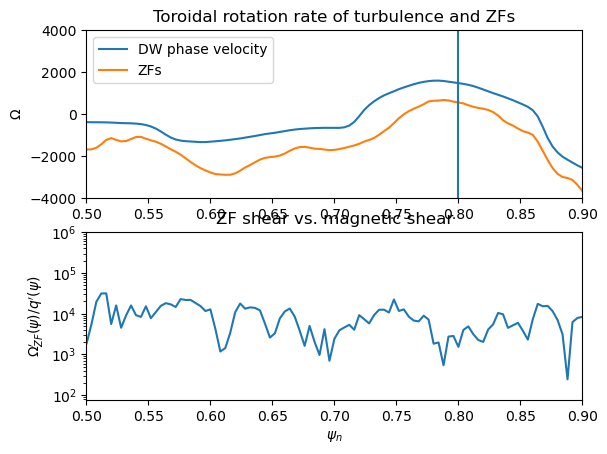

In [3]:
# %% Plot phase space velocities

plt.figure()

ax = plt.subplot(211)
plt.plot(geom.psi_surf / eq.psix, uph[tind,:] * geom.q_surf, label='DW phase velocity')
plt.plot(geom.psi_surf / eq.psix, -zonalFields.interp_phi(geom.psi_surf, nu=1), label='ZFs')
plt.axvline(geom.psi_surf[200] / eq.psix)
plt.ylabel(R'$\Omega$')
plt.title('Toroidal rotation rate of turbulence and ZFs')

plt.legend()

plt.xlim(0.5, 0.9)
plt.ylim(-4000,4000)

plt.subplot(212, sharex=ax)
plt.semilogy(geom.psi_surf / eq.psix, np.abs(zonalFields.interp_phi(geom.psi_surf, nu=2)) / np.abs(geom.interp_q(geom.psi_surf, nu=1)))
#plt.semilogy(geom.psi_surf / eq.psix, )
plt.title('ZF shear vs. magnetic shear')
plt.xlabel(R'$\psi_n$')
plt.ylabel(R"$\Omega_{ZF}'(\psi) / q'(\psi)$")


## Particle Pushing

In [14]:
# %% Set up particle properties

# Set up rotating frame
tind0 = 400
ksurf_ref = 196
omega_frame = -uph[tind0,ksurf_ref]*geom.q_surf[ksurf_ref]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(0, omega_frame, tind0)
t0 = rotating_frame.t0

# Set up particle properties
pp = particle_motion.deut

# Grid of reference particle kinetic energies in keV
kev_grid = np.array([0.78])

# Grid for pitch angles cos(theta), where theta is the angle between v and B.
xi_grid = np.array([-np.sqrt(0.67), np.sqrt(0.33), np.sqrt(0.67)])

# Grid for number of radial initial conditions
r0 = eq.interp_router(geom.psi_surf[ksurf_ref]/eq.psix)
r_grid = np.linspace(r0-0.01, r0+0.03, num=32)

## Array to hold the solutions
sol_array = np.empty((len(kev_grid), len(xi_grid), len(r_grid)), dtype=object)


for k_e in range(len(kev_grid)):
    for k_xi in range(len(xi_grid)):
        ## Set up the reference AnalysisData object, which will compute the integrals for us
        analysis_data = dict(
            name='trapped',
            ksurf=ksurf_ref,
            ev0=kev_grid[k_e],
            xi0=xi_grid[k_xi],
            pp=pp,
        )
        analysis = analysis_setup.MidplaneAnalysisData(
            **analysis_data,
            geom=geom,
            zonalFields=zonalFields,
            frame=rotating_frame
        )

        ## Get and unpack the integrals
        integrals = analysis.get_reference_integrals()
        rotating_frame, ham0, lphi0, mu0 = integrals
        
        print('K = {}; cos(xi) = {}'.format(kev_grid[k_e], xi_grid[k_xi]))
        
        for k_psin in tqdm(range(len(r_grid))):
            r = r_grid[k_psin]
            
            bv = eq.compute_bv(r, 0)
            modb = np.linalg.norm(bv)
            bu = bv / modb

            kll, pll_mean = particle_tools.compute_parallel_energy(t0, r, 0, 0, mu0, ham0, lphi0, eq, pp, zonalFields, rotating_frame)
            
            # Check if the term in the square root is positive, i.e. check for admissibility
            if (kll) < 0:
                continue
            else:
                x0 = np.array([r, 0, 0])
                vll0 = (pll_mean + np.sign(xi_grid[k_xi]) * np.sqrt(2 * pp.m * kll)) / pp.m
                
                z0 = np.concatenate((x0, [vll0, mu0]))
                
                dz0 = particle_motion.f_driftkinetic(0, z0, eq, pp, zonalFields)
                
                event_transit = particle_motion.event_copassing if dz0[2] > 0 else particle_motion.event_ctrpassing
                
                sol_array[k_e,k_xi,k_psin] = scipy.integrate.solve_ivp(particle_motion.f_driftkinetic,
                                                   [0, 300], z0,
                                                   atol=1e-8, rtol=1e-8,
                                                   args=(eq, pp, zonalFields),
                                                   events=[event_transit, particle_motion.event_botloss])


K = 0.78; cos(xi) = -0.8185352771872451


100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


K = 0.78; cos(xi) = 0.5744562646538028


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


K = 0.78; cos(xi) = 0.8185352771872451


100%|██████████| 48/48 [00:09<00:00,  5.01it/s]


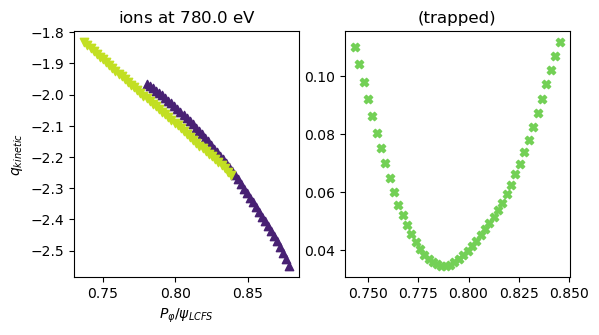

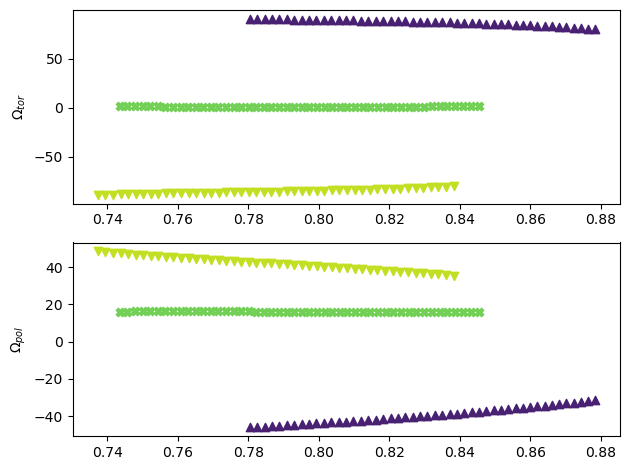

In [17]:

# %% Compute and plot frequencies

k_kev = 0

plt.figure(figsize=(6.4,3.2))
ax = plt.subplot(121)
axt = plt.subplot(122)
#ax = plt.subplot(111)

plt.figure()
ax_tor = plt.subplot(211)
ax_pol = plt.subplot(212)

for k_xi in range(len(xi_grid)):
#for k_xi in [2,-3]:
    for k in range(len(r_grid)):
        if sol_array[k_kev,k_xi,k] is None:
            continue
        elif len(sol_array[k_kev,k_xi,k].t_events[1]) > 0:
            continue
        else:
            sol = sol_array[k_kev,k_xi,k]
            #rplot, thplot = rz_to_pol(sol.y[0,:], sol.y[2,:])
            #ax.plot(thplot, rplot)
            #ax.plot(sol.y[0,:], sol.y[2,:])
            omega_tor, omega_pol, j_axis = particle_tools.compute_frequencies(sol.t, sol.y[0,:], sol.y[2,:], sol.y[1,:], eq, rotating_frame)

            #ham_sol, lphi_sol, mu_sol = particle_motion.compute_integrals_dk(sol, eq, pp, fields, initial=True)
            
            #print(np.median(np.diff(sol.t)))

            #plot_color = mpl.cm.viridis((mu_grid[k_kev,k_xi] - np.min(mu_grid)) / (np.max(mu_grid) - np.min(mu_grid)))
            #plot_color = mpl.cm.viridis(np.abs(xi_grid[k_xi]))
            plot_color = mpl.cm.viridis(xi_grid[k_xi]/2+0.5)
            
            if j_axis == 0:
                plot_marker = 'X' if omega_pol > 0 else 'o'
            else:
                plot_marker = '^' if omega_tor > 0 else 'v'
            
            
            #psi_sol = eq.interp_psi.ev(sol.y[0,:], sol.y[2,:])
            #psi_avg = scipy.integrate.simpson(psi_sol, x=sol.t) / (sol.t[-1] - sol.t[0])
            ham, lphi = particle_tools.compute_integrals_dk(sol.t[0], sol.y[:,0], eq, pp, zonalFields, rotating_frame)
            psi_avg = lphi
            
            
            # Split plotting trapped and passing particles
            if j_axis != 0:
                ax.scatter(psi_avg / eq.psix, (omega_tor)/omega_pol, marker=plot_marker, color=plot_color)
            else:
                plot_color = mpl.cm.viridis(np.abs(xi_grid[k_xi])/2+0.5)
                axt.scatter(psi_avg / eq.psix, (omega_tor)/omega_pol, marker=plot_marker, color=plot_color)
            
            
            #ax.scatter(psi_avg / eq.psix, -(omega_tor + omega_adiabat)/omega_pol, marker=plot_marker, color=plot_color)
            ax_tor.scatter(psi_avg / eq.psix, omega_tor, marker=plot_marker, color=plot_color)
            ax_pol.scatter(psi_avg / eq.psix, omega_pol, marker=plot_marker, color=plot_color)

            #ax.scatter(psi_avg / eq.psix, -omega_tor/omega_pol, marker=plot_marker, color=plot_color)
            #axt.scatter(psi_avg / eq.psix, 1/omega_pol, marker=plot_marker, color=plot_color)


#ax.set_xlabel(r'$\langle\psi\rangle / \psi_{LCFS}$')
#axt.set_xlabel(r'$\langle\psi\rangle / \psi_{LCFS}$')
ax.set_xlabel(r'$P_{\varphi} / \psi_{LCFS}$')
#axt.set_xlabel(r'$P_{\varphi} / \psi_{LCFS}$')
ax.set_ylabel(r'$q_{kinetic}$')

ax_tor.set_ylabel(R'$\Omega_{tor}$')
ax_pol.set_ylabel(R'$\Omega_{pol}$')

patches = []
labels = []

#axt.plot(psin_grid, -fields.interp_phi(psin_grid*eq.psix, nu=1) / 40)

ax.set_title('{} at ${}$ eV'.format('electrons' if pp.z < 0 else 'ions', kev_grid[k_kev]*1e3))
#ax.legend(patches, labels, handler_map = {tuple: mpl.legend_handler.HandlerTuple(ndivide=None)}, title=r'$\mu B_{LFS}$ [eV]')
axt.set_title('(trapped)')

np.savez('./outputs/phase_space_analysis_sol.npz', t=sol.t, y=sol.y)

plt.tight_layout()
plt.show()